In [29]:
import sys
import os
import pickle
from scipy import sparse
import scanpy as sc
import anndata as ad
from anndata import AnnData
import scvi
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn

from perturbnet.util import * 
from perturbnet.cinn.flow import * 
from perturbnet.chemicalvae.chemicalVAE import *
from perturbnet.data_vae.vae import *
from perturbnet.cinn.flow_generate import TFVAEZ_CheckNet2Net
from tqdm import tqdm
import pickle5
from perturbnet.baselines.knn import *
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import Ridge

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Preparation

In [13]:
#some_path = ""

#path_cinn_model = some_path + 'cinn_iso_clean/100ep/100ep/'
#path_data = ""
#path_chemvae_model = some_path + "/chemicalvae/zinc/model_params_525.pt"


#path_vae_model_train = some_path + '/cellvae/150ep/model/'
#path_chem_onehot = some_path + "/zinc/"

adata = ad.read_h5ad(os.path.join(path_data, "lincs_corrected_isoforms_splits.h5ad"))
with open(some_path + "/LINCS-Drugs/rank_genes_group.pkl", "rb") as fh:
    degs = pickle5.load(fh)
adata.uns["rank_genes_groups"] = degs
    
adata_save_index = np.array(adata.obs[adata.obs["perturb_string_chemvae_flag"] == 1].index).astype(int)
adata = adata[adata_save_index, :].copy()    
print(adata.obs.shape)
adata.obs = adata.obs.reset_index()
    
adata_save_index = np.array(adata.obs[adata.obs["chem_iso_saved_flag"] != "iso_removed"].index).astype(int)
adata = adata[adata_save_index, :].copy()    
print(adata.obs.shape)
adata.obs = adata.obs.reset_index(drop = True)
    
adata_test_index = np.array(adata.obs[adata.obs["holdout1"] == "test"].index).astype(int)
adata_test = adata[adata_test_index, :].copy()
    
adata_train_index = np.array(adata.obs[adata.obs["holdout1"] == "train"].index).astype(int)
adata_train = adata[adata_train_index, :].copy()
data_chem_onehot = np.load(os.path.join(path_chem_onehot, "onehot_zinc.npy"))
usedata = adata_test.X
alldata = adata.X

perturb_with_onehot_kept, perturb_with_onehot_removed = np.array(adata_train.obs["perturb_string"]), np.array(adata_test.obs["perturb_string"])
trt_obs_list, trt_unseen_list = np.unique(perturb_with_onehot_kept), np.unique(perturb_with_onehot_removed)    
onehot_unseen_idx = []
for i in range(len(trt_unseen_list)):
    trt = trt_unseen_list[i]
    onehot_idx = np.where(adata.uns["ordered_all_smile"] == trt)[0][0]
    onehot_unseen_idx.append(onehot_idx)
    unseen_onehot = adata.uns["ordered_all_onehot"][onehot_unseen_idx]

onehot_seen_idx = []
for i in range(len(trt_obs_list)):
    trt = trt_obs_list[i]
    onehot_idx = np.where(adata.uns["ordered_all_smile"] == trt)[0][0]
    onehot_seen_idx.append(onehot_idx)
seen_onehot = adata.uns["ordered_all_onehot"][onehot_seen_idx]    
    





#Zsample = vae_train.encode(usedata)


(674279, 28)


/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


(527626, 29)


# PerturbNet

In [14]:
vae_train = VAE(num_cells_train = usedata.shape[0], x_dimension = usedata.shape[1], learning_rate = 1e-4, BNTrainingMode = False)
vae_train.restore_model(tf.train.latest_checkpoint(path_vae_model_train))

# (2) load models
device = "cuda" if torch.cuda.is_available() else "cpu"

model_chemvae = ChemicalVAE(n_char = data_chem_onehot.shape[2],max_len = data_chem_onehot.shape[1]).to(device)
model_chemvae.load_state_dict(torch.load(path_chemvae_model, map_location = device))
model_chemvae.eval()


std_model = Standardize(data_all = data_chem_onehot, model = model_chemvae, device = device)



perturbToOnehot = {}
for i in range(trt_unseen_list.shape[0]):
    perturbToOnehot[trt_unseen_list[i]] = i    
        
        
torch.manual_seed(42)
flow_model = ConditionalFlatCouplingFlow(conditioning_dim = 196,embedding_dim = 10, conditioning_depth = 2, n_flows = 20, 
                               in_channels = 10, hidden_dim = 1024, hidden_depth = 2, activation = "none", conditioner_use_bn = True)

model_c = Net2NetFlow_TFVAEFlow(configured_flow = flow_model, first_stage_data = usedata, cond_stage_data = perturb_with_onehot_removed,
                          perturbToOnehotLib = perturbToOnehot, oneHotData = unseen_onehot, model_con = model_chemvae, 
                          std_model = std_model,sess = vae_train.sess, enc_ph = vae_train.x, z_gen_data_v = vae_train.z_mean,
                          is_training = vae_train.is_training)

model_c.to(device = device)

model_c.load(path_cinn_model)
model_c.eval()

model_g = model_c.model_con
model_g.eval()

perturbnet_model = TFVAEZ_CheckNet2Net(model_c, device, vae_train.sess, vae_train.x_hat, vae_train.z_mean, vae_train.is_training)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Use keras.layers.dropout instead.

Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update a

2025-04-21 21:35:33.929404: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2025-04-21 21:35:33.997084: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2500000000 Hz
2025-04-21 21:35:33.999945: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x561891e98cf0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-04-21 21:35:33.999982: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-04-21 21:35:34.006002: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device





2025-04-21 21:35:34.158744: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56189eaddc10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-21 21:35:34.158763: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-16GB, Compute Capability 7.0
2025-04-21 21:35:34.159114: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla V100-PCIE-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.38
pciBusID: 0000:d8:00.0
2025-04-21 21:35:34.171103: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2025-04-21 21:35:34.174919: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2025-04-21 21:35:34.235538: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2025-

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
encoder/dense/kernel/Initializer/random_uniform/RandomUniform: (RandomUniform): /job:localhost/replica:0/task:0/device:CPU:0
encoder/dense/kernel/Initializer/random_uniform/sub: (Sub): /job:localhost/replica:0/task:0/device:CPU:0
encoder/dense/kernel/Initializer/random_uniform/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
encoder/dense/kernel/Initializer/random_uniform: (Add): /job:localhost/replica:0/task:0/device:CPU:0
encoder/dense/kernel: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
encoder/dense/kernel/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
encoder/dense/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
encoder/dense/bias: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
encoder/dense/bias/Assign: (Assign): /job:localhost/replica:0/task:0/d

2025-04-21 21:35:34.410035: W tensorflow/core/common_runtime/colocation_graph.cc:983] Failed to place the graph without changing the devices of some resources. Some of the operations (that had to be colocated with resource generating operations) are not supported on the resources' devices. Current candidate devices are [
  /job:localhost/replica:0/task:0/device:CPU:0].
See below for details of this colocation group:
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=-1 requested_device_name_='/device:GPU:0' assigned_device_name_='' resource_device_name_='/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
ApplyAdam: CPU 
Fill: CPU XLA_CPU XLA_GPU 
Assign: CPU 
VariableV2: CPU 
Identity: CPU XLA_CPU XLA_GPU 
Add: CPU XLA_CPU XLA_GPU 
Mul: CPU XLA_CPU XLA_GPU 
Sub: CPU XLA_CPU XLA_GPU 
RandomUniform: CPU XLA_CPU XLA_GPU 
Const: CPU XLA_CPU XLA_GPU 

Colocation members, user-requested devices, and f

INFO:tensorflow:Restoring parameters from /nfs/turbo/umms-welchjd/wzqian/model_save/lincs-drug-newsplit/PerturbNet/holdout1/cellvae/150ep/model/model-151
Note: Conditioning network uses batch-normalization. Make sure to train with a sufficiently large batch size


In [15]:
fidscore_cal = fidscore()
adata.var["gene_idx"] = np.arange(0,adata.var.shape[0],1)
perturb = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []
pear = []
pear_deg = []
pear_large = []
np.random.seed(2023)

    
    
for indice_trt in range(len(trt_unseen_list)):

    trt_type = trt_unseen_list[indice_trt]
    pert = trt_type
    
    idx_trt_type = np.where(perturb_with_onehot_removed == trt_type)[0]

    if idx_trt_type.shape[0] > 1000:
        idx_trt_type = np.random.choice(idx_trt_type, 1000, replace = False)
    # make eval consistent with chemcpa
    elif idx_trt_type.shape[0] <= 5:
        continue  
    if pert == "CS(=O)C":
        continue

    #onehot_indice_trt = np.tile(unseen_onehot[[indice_trt]], (len(idx_trt_type), 1, 1))
    onehot_indice_trt = np.tile(unseen_onehot[[indice_trt]], (500, 1, 1))
    _, _, _, embdata_torch = model_g(torch.tensor(onehot_indice_trt).float().to(device))
    embdata_np = std_model.standardize_z(embdata_torch.cpu().detach().numpy())
        
    DEG_gene = adata.uns["rank_genes_groups"]["names"][trt_type]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])

    real_data = usedata[idx_trt_type]
    _, fake_data = perturbnet_model.sample_data(embdata_np)
        
    ## evaluation
    r2_value = fidscore_cal.calculate_r_square(real_data, fake_data)
    pear_value = fidscore_cal.calculate_pearson(real_data, fake_data)

        
    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]


    r2_deg_value = fidscore_cal.calculate_r_square(real_data_deg, fake_data_deg)
    pear_deg_value =  fidscore_cal.calculate_pearson(real_data_deg, fake_data_deg)
    
    large_effect_idx =  DEG_idx[abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1]

    num_large =  sum(abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1)
        
    if num_large <=1:
        r2_large_value=1.5
        pear_large_value=1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]
        r2_large_value = fidscore_cal.calculate_r_square(real_data_large, fake_data_large)
        pear_large_value = fidscore_cal.calculate_pearson(real_data_large , fake_data_large)
        

    perturb.append(pert)
    ncell.append(len(idx_trt_type))
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)
    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)


results_PerturbNet = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,
                        "r2":r2,
                        "r2_deg":r2_deg,
                        "r2_large":r2_large,
                         "pear":pear,
                        "pear_deg":pear_deg,
                        "pear_large":pear_large
                       })
    

In [21]:
data_path = "/nfs/turbo/umms-welchjd/wzqian/data/chemcpa_output/new-test-splits/holdout1/pred_dict_iso_clean.pkl"

# ChemCPA

In [22]:
#data_path = some_path + "pred_dict_iso_clean.pkl"
with open(data_path, "rb") as fh:
    pred_dict = pickle5.load(fh)
    
    
perturb = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []
pear = []
pear_deg = []
pear_large = []
np.random.seed(2023)


for pert, pred  in tqdm(pred_dict.items()):
    

    fake_data = pred[0]
    real_data = pred[1]
    real_data = real_data.detach().numpy()
    fake_data = fake_data.detach().numpy()

    if real_data.shape[0] > 1000:
        real_data = real_data[np.random.choice(real_data.shape[0], 1000, replace = False)]
    elif real_data.shape[0] <= 5:
        continue


    DEG_gene = adata.uns["rank_genes_groups"]["names"][pert]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])
    
    
    r2_value = fidscore_cal.calculate_r_square(real_data, fake_data)
    pear_value = fidscore_cal.calculate_pearson(real_data, fake_data)


        
    ## Extra evaluation on DEG rsquare
    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]


    r2_deg_value = fidscore_cal.calculate_r_square(real_data_deg, fake_data_deg)
    pear_deg_value =  fidscore_cal.calculate_pearson(real_data_deg, fake_data_deg)

    
    large_effect_idx =  DEG_idx[abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1]

    num_large =  sum(abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1)


    if num_large <=1:
        r2_large_value=1.5
        pear_large_value=1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]
        r2_large_value = fidscore_cal.calculate_r_square(real_data_large, fake_data_large)
        pear_large_value =  fidscore_cal.calculate_pearson(real_data_large, fake_data_large)

    perturb.append(pert)
    ncell.append(real_data.shape[0])
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)
    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)
results_chemCPA = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,
                        "r2":r2,
                        "r2_deg":r2_deg,
                        "r2_large":r2_large,
                         "pear":pear,
                        "pear_deg":pear_deg,
                        "pear_large":pear_large
                       })

100%|██████████| 1888/1888 [00:05<00:00, 340.95it/s]


# Training Sample

In [23]:
adata.var["gene_idx"] = np.arange(0,adata.var.shape[0],1)
perturb = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []
pear = []
pear_deg = []
pear_large = []
np.random.seed(2023)
count = 0
    
for indice_trt in range(len(trt_unseen_list)):

    trt_type = trt_unseen_list[indice_trt]
    pert = trt_type
    
    seen_data = adata_train.X
    seen_data_idx = list(range(seen_data.shape[0]))
    idx_trt_type = np.where(perturb_with_onehot_removed == trt_type)[0]
    if idx_trt_type.shape[0] > 1000:
        idx_trt_type = np.random.choice(idx_trt_type, 1000, replace = False)
    # make eval consistent with chemcpa
    elif idx_trt_type.shape[0] <= 5:
        continue  
    
    if pert == "CS(=O)C":
        continue
        
    DEG_gene = adata.uns["rank_genes_groups"]["names"][trt_type]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])

    real_data = usedata[idx_trt_type]
    
    idx_rsample = np.random.choice(seen_data_idx, len(idx_trt_type), replace=True)
    fake_data = seen_data[idx_rsample]

        ## evaluation
    r2_value = fidscore_cal.calculate_r_square(real_data, fake_data)
    pear_value = fidscore_cal.calculate_pearson(real_data, fake_data)


        
    ## Extra evaluation on DEG rsquare
    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]


    r2_deg_value = fidscore_cal.calculate_r_square(real_data_deg, fake_data_deg)
    pear_deg_value = fidscore_cal.calculate_pearson(real_data_deg, fake_data_deg)
    
    large_effect_idx =  DEG_idx[abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1]

    num_large =  sum(abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1)
    if num_large <=1:
        hd_large_value=1.5
        r2_large_value=1.5
        pear_large_value=1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]
        r2_large_value = fidscore_cal.calculate_r_square(real_data_large, fake_data_large)
        pear_large_value =  fidscore_cal.calculate_pearson(real_data_large , fake_data_large)
        
    perturb.append(pert)
    ncell.append(len(idx_trt_type))
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)

    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)
    
results_sample = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,
                        "r2":r2,
                        "r2_deg":r2_deg,
                        "r2_large":r2_large,
                         "pear":pear,
                        "pear_deg":pear_deg,
                        "pear_large":pear_large})

# KNN

In [24]:
_, _, _, embdata_torch_seen = model_chemvae(torch.tensor(seen_onehot).float().to(device))
embdata_numpy_seen = std_model.standardize_z(embdata_torch_seen.cpu().detach().numpy())
_, _, _, embdata_torch_unseen = model_chemvae(torch.tensor(unseen_onehot).float().to(device))
embdata_numpy_unseen = std_model.standardize_z(embdata_torch_unseen.cpu().detach().numpy())

neigh = NearestNeighbors(n_neighbors=5)
neigh_fit = neigh.fit(embdata_numpy_seen)

adata.var["gene_idx"] = np.arange(0,adata.var.shape[0],1)
perturb = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []
pear = []
pear_deg = []
pear_large = []
np.random.seed(2023)
seen_data = adata_train.X
seen_data_idx = list(range(seen_data.shape[0]))    

for indice_trt in tqdm(range(len(trt_unseen_list))):

    trt_type = trt_unseen_list[indice_trt]
    pert = trt_type
    

    idx_trt_type = np.where(perturb_with_onehot_removed == trt_type)[0]
    if idx_trt_type.shape[0] > 1000:
        idx_trt_type = np.random.choice(idx_trt_type, 1000, replace = False)
    # make eval consistent with chemcpa
    elif idx_trt_type.shape[0] <= 5:
        continue  
    
    if pert == "CS(=O)C":
        continue
        
    DEG_gene = adata.uns["rank_genes_groups"]["names"][trt_type]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])

    real_data = usedata[idx_trt_type]
    
    distances, other_trts = neigh_fit.kneighbors(embdata_numpy_unseen[[indice_trt]], 5, return_distance=True)
    samplerNN = samplefromNeighbors(distances, other_trts)
    idx_sample = samplerNN.samplingTrt(trt_obs_list, perturb_with_onehot_kept, len(idx_trt_type))
    
    #idx_rsample = np.random.choice(seen_data_idx, len(idx_trt_type), replace=True)
    fake_data = seen_data[idx_sample]

        ## evaluation
    r2_value = fidscore_cal.calculate_r_square(real_data, fake_data)
    pear_value = fidscore_cal.calculate_pearson(real_data, fake_data)

    
    ## Extra evaluation on DEG rsquare
    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]


    r2_deg_value = fidscore_cal.calculate_r_square(real_data_deg, fake_data_deg)
    pear_deg_value = fidscore_cal.calculate_pearson(real_data_deg, fake_data_deg)
    
    large_effect_idx =  DEG_idx[abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1]

    num_large =  sum(abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1)
    if num_large <=1:
        hd_large_value=1.5
        r2_large_value=1.5
        pear_large_value=1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]
        r2_large_value = fidscore_cal.calculate_r_square(real_data_large, fake_data_large)
        pear_large_value =  fidscore_cal.calculate_pearson(real_data_large , fake_data_large)
        
    perturb.append(pert)
    ncell.append(len(idx_trt_type))
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)

    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)
    
results_KNN = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,
                        "r2":r2,
                        "r2_deg":r2_deg,
                        "r2_large":r2_large,
                         "pear":pear,
                        "pear_deg":pear_deg,
                        "pear_large":pear_large})


100%|██████████| 1988/1988 [03:58<00:00,  8.34it/s]


# Mean and Median

In [26]:
adata.var["gene_idx"] = np.arange(0,adata.var.shape[0],1)
perturb = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []
pear = []
pear_deg = []
pear_large = []
np.random.seed(2023)
seen_data = adata_train.X
mean_seen = np.mean(seen_data,axis = 0)
for indice_trt in tqdm(range(len(trt_unseen_list))):

    trt_type = trt_unseen_list[indice_trt]
    pert = trt_type
    

    idx_trt_type = np.where(perturb_with_onehot_removed == trt_type)[0]
    if idx_trt_type.shape[0] > 1000:
        idx_trt_type = np.random.choice(idx_trt_type, 1000, replace = False)
    # make eval consistent with chemcpa
    elif idx_trt_type.shape[0] <= 5:
        continue  
    
    if pert == "CS(=O)C":
        continue
        
    DEG_gene = adata.uns["rank_genes_groups"]["names"][trt_type]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])

    real_data = usedata[idx_trt_type]

    fake_data = np.tile(mean_seen,(real_data.shape[0],1))

    r2_value = fidscore_cal.calculate_r_square(real_data, fake_data)
    pear_value = fidscore_cal.calculate_pearson(real_data, fake_data)

    
    ## Extra evaluation on DEG rsquare
    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]


    r2_deg_value = fidscore_cal.calculate_r_square(real_data_deg, fake_data_deg)
    pear_deg_value = fidscore_cal.calculate_pearson(real_data_deg, fake_data_deg)
    
    large_effect_idx =  DEG_idx[abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1]

    num_large =  sum(abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1)
    if num_large <=1:
        hd_large_value=1.5
        r2_large_value=1.5
        pear_large_value=1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]
        r2_large_value = fidscore_cal.calculate_r_square(real_data_large, fake_data_large)
        pear_large_value =  fidscore_cal.calculate_pearson(real_data_large , fake_data_large)
        
    perturb.append(pert)
    ncell.append(len(idx_trt_type))
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)


    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)
    
results_mean = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,
                        "r2":r2,
                        "r2_deg":r2_deg,
                        "r2_large":r2_large,
                         "pear":pear,
                        "pear_deg":pear_deg,
                        "pear_large":pear_large})


perturb = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []
pear = []
pear_deg = []
pear_large = []
np.random.seed(2023)
seen_data = adata_train.X
median_seen = np.median(seen_data,axis = 0)
for indice_trt in tqdm(range(len(trt_unseen_list))):

    trt_type = trt_unseen_list[indice_trt]
    pert = trt_type
    

    idx_trt_type = np.where(perturb_with_onehot_removed == trt_type)[0]
    if idx_trt_type.shape[0] > 1000:
        idx_trt_type = np.random.choice(idx_trt_type, 1000, replace = False)
    # make eval consistent with chemcpa
    elif idx_trt_type.shape[0] <= 5:
        continue  
    
    if pert == "CS(=O)C":
        continue
        
    DEG_gene = adata.uns["rank_genes_groups"]["names"][trt_type]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])

    real_data = usedata[idx_trt_type]

    fake_data = np.tile(median_seen,(real_data.shape[0],1))

    r2_value = fidscore_cal.calculate_r_square(real_data, fake_data)
    pear_value = fidscore_cal.calculate_pearson(real_data, fake_data)


    
    ## Extra evaluation on DEG rsquare
    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]


    r2_deg_value = fidscore_cal.calculate_r_square(real_data_deg, fake_data_deg)
    pear_deg_value = fidscore_cal.calculate_pearson(real_data_deg, fake_data_deg)
    
    large_effect_idx =  DEG_idx[abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1]

    num_large =  sum(abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1)
    if num_large <=1:
        hd_large_value=1.5
        r2_large_value=1.5
        pear_large_value=1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]
        r2_large_value = fidscore_cal.calculate_r_square(real_data_large, fake_data_large)
        pear_large_value =  fidscore_cal.calculate_pearson(real_data_large , fake_data_large)
        
    perturb.append(pert)
    ncell.append(len(idx_trt_type))
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)

    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)
    
results_median = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,
                        "r2":r2,
                        "r2_deg":r2_deg,
                        "r2_large":r2_large,
                         "pear":pear,
                        "pear_deg":pear_deg,
                        "pear_large":pear_large})


100%|██████████| 1988/1988 [00:10<00:00, 181.08it/s]


# Linear

In [30]:
expanded_seen_embeddings = []
for indice_trt in tqdm(range(len(trt_obs_list))):
    trt_type = trt_obs_list[indice_trt ]
    idx_trt_type = np.where(perturb_with_onehot_kept == trt_type)[0]

    onehot_indice_trt = np.tile(seen_onehot[[indice_trt]], (len(idx_trt_type), 1, 1))  # Expand to 500 samples
    _, _, _, embdata_torch = model_chemvae(torch.tensor(onehot_indice_trt).float().to(device))
    embdata_np = std_model.standardize_z(embdata_torch.cpu().detach().numpy())
    expanded_seen_embeddings.append(embdata_np)

# Merge into training data
expanded_seen_embeddings = np.vstack(expanded_seen_embeddings)


X_train = expanded_seen_embeddings
Y_train = adata_train.X



ridge = Ridge(alpha=0.1)  # Ridge regression with penalty 0.1
ridge.fit(X_train, Y_train)


fidscore_cal = fidscore()
adata.var["gene_idx"] = np.arange(0,adata.var.shape[0],1)
perturb = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []


pear = []
pear_deg = []
pear_large = []
np.random.seed(2023)
count = 0
#seen_data = adata_train.X
#seen_data_idx = list(range(seen_data.shape[0]))    

for indice_trt in tqdm(range(len(trt_unseen_list))):

    trt_type = trt_unseen_list[indice_trt]
    pert = trt_type
    

    idx_trt_type = np.where(perturb_with_onehot_removed == trt_type)[0]
    if idx_trt_type.shape[0] > 1000:
        idx_trt_type = np.random.choice(idx_trt_type, 1000, replace = False)
    # make eval consistent with chemcpa
    elif idx_trt_type.shape[0] <= 5:
        continue  
    
    if pert == "CS(=O)C":
        continue
        
    DEG_gene = adata.uns["rank_genes_groups"]["names"][trt_type]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])
    onehot_indice_trt = np.tile(unseen_onehot[[indice_trt]], (500, 1, 1))
    _, _, _, embdata_torch = model_chemvae(torch.tensor(onehot_indice_trt).float().to(device))
    embdata_np = std_model.standardize_z(embdata_torch.cpu().detach().numpy())
    real_data = usedata[idx_trt_type]
    fake_data = ridge.predict( embdata_np )

    r2_value = fidscore_cal.calculate_r_square(real_data, fake_data)
    pear_value = fidscore_cal.calculate_pearson(real_data, fake_data)

    
    ## Extra evaluation on DEG rsquare
    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]


    r2_deg_value = fidscore_cal.calculate_r_square(real_data_deg, fake_data_deg)
    pear_deg_value = fidscore_cal.calculate_pearson(real_data_deg, fake_data_deg)
    
    large_effect_idx =  DEG_idx[abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1]

    num_large =  sum(abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1)
    if num_large <=1:
        hd_large_value=1.5
        r2_large_value=1.5
        pear_large_value=1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]
        r2_large_value = fidscore_cal.calculate_r_square(real_data_large, fake_data_large)
        pear_large_value =  fidscore_cal.calculate_pearson(real_data_large , fake_data_large)
        
    perturb.append(pert)
    ncell.append(len(idx_trt_type))
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)
    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)
    
results_linear = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,
                        "r2":r2,
                        "r2_deg":r2_deg,
                        "r2_large":r2_large,
                         "pear":pear,
                        "pear_deg":pear_deg,
                        "pear_large":pear_large})


100%|██████████| 1988/1988 [02:00<00:00, 16.44it/s]


/nfs/turbo/umms-welchjd/wzqian/conda_env_new/test_2/lib/python3.7/site-packages/perturbnet/util.py:886: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


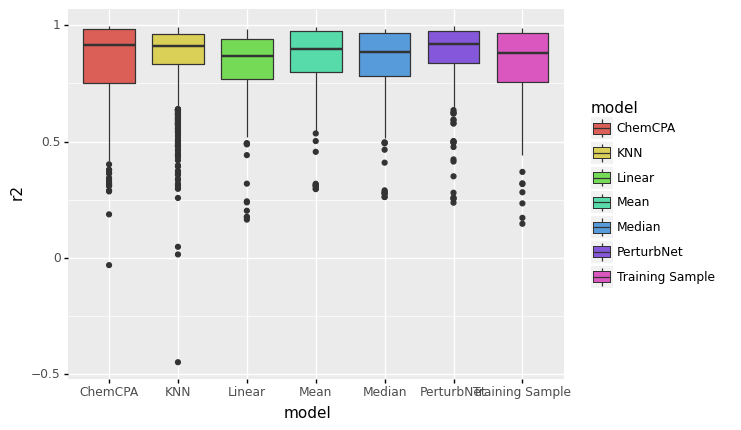

<ggplot: (1455681041813)>

In [32]:
boxplot_metrics({"PerturbNet":results_PerturbNet, "ChemCPA":results_chemCPA, "Training Sample":results_sample,
                "KNN": results_KNN,"Mean":results_mean, "Median":results_median, "Linear":results_linear  }, metric_key = "r2")

/nfs/turbo/umms-welchjd/wzqian/conda_env_new/test_2/lib/python3.7/site-packages/perturbnet/util.py:886: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


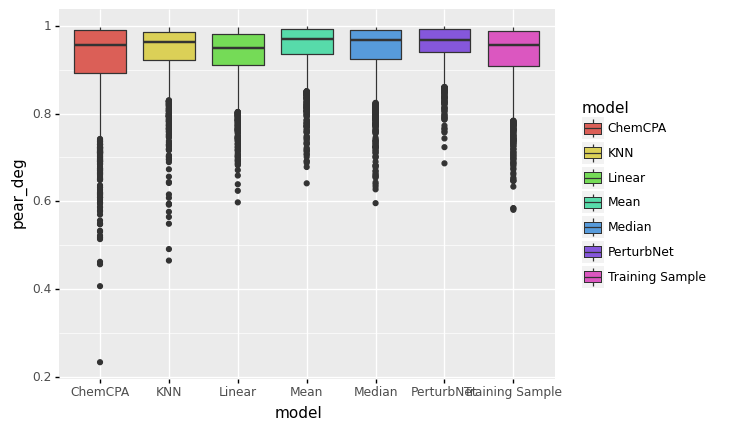

<ggplot: (1455681665645)>

In [33]:
boxplot_metrics({"PerturbNet":results_PerturbNet, "ChemCPA":results_chemCPA, "Training Sample":results_sample,
                "KNN": results_KNN,"Mean":results_mean, "Median":results_median, "Linear":results_linear }, metric_key = "pear_deg")